# Import packages

In [1]:
from google.colab import drive, auth
auth.authenticate_user()
import requests
gcloud_token = !gcloud auth print-access-token
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open('/content/drive/My Drive/Colab Notebooks/Assignment_1_Script.py') as infile:
    exec(infile.read())

# Prepare Data

In [0]:
excelfile = '/content/drive/My Drive/Data/Assignment_1_Data_and_Template.xlsx'

In [0]:
data=readExcel(excelfile)
X=np.array(data[:,0]*12+data[:,1],dtype=float)
T=np.array(data[:,2])

In [5]:
queries=(readExcel(excelfile,
                  sheetname='Queries',
                  startrow=3,
                  endrow=8,
                  startcol=1,
                  endcol=1)).astype(float);queries

array([55., 60., 65., 70., 75., 80.])

# Histogram

### Full Data Histogram Classifier

In [0]:
def BuildHistogramClassifiers(X, T, B, minheight, maxheight):
  HF = np.zeros(B).astype(int)
  HM = np.zeros(B).astype(int)
  binindices = np.round((B-1)*(X - minheight)/(maxheight - minheight)).astype(int)
  for i, b in enumerate(binindices):
    if T[i]=='Female':
      HF[b]+=1
    else:
      HM[b]+=1
  return [HF, HM]

In [0]:
B = 32
minheight = np.amin(X)
maxheight = np.amax(X)
[HF, HM] = BuildHistogramClassifiers(X, T, B, minheight, maxheight)

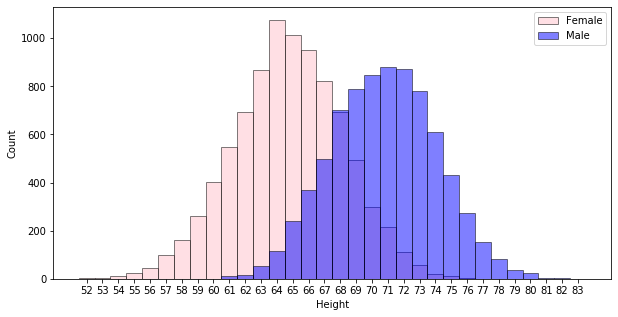

In [8]:
showHistograms(HF, HM, minheight, maxheight)

In [0]:
def ApplyHistogramClassifiers(queries, HF, HM, minheight, maxheight):
  B = len(HF)
  binindices = np.round((B-1)*(queries - minheight)/(maxheight - minheight)).astype(int)
  countF = HF[binindices]
  countM = HM[binindices]
  resultlabels = np.full(len(queries), 'Indeterminate', dtype=object)
  resultprobs = np.full(len(queries), np.nan, dtype=object)
  indicesF = countF>countM
  indicesM = countM>countF
  probF=countF/(countF+countM)
  probM=countM/(countF+countM)
  resultlabels[indicesF] = 'Female'
  resultlabels[indicesM] = 'Male'
  resultprobs[indicesF] = probF[indicesF]
  resultprobs[indicesM] = probM[indicesM]
  return [resultlabels, resultprobs]

In [0]:
[GH, PH] = ApplyHistogramClassifiers(queries, HF, HM, minheight, maxheight)

In [12]:
ApplyHistogramClassifiers([68], HF, HM, minheight, maxheight)

[array(['Male'], dtype=object), array([0.5017921146953405], dtype=object)]

In [13]:
showResult(queries, GH, PH)

   Query  Gender Probability
0   55.0  Female           1
1   60.0  Female    0.997531
2   65.0  Female    0.807815
3   70.0    Male    0.739547
4   75.0    Male    0.972973
5   80.0    Male           1


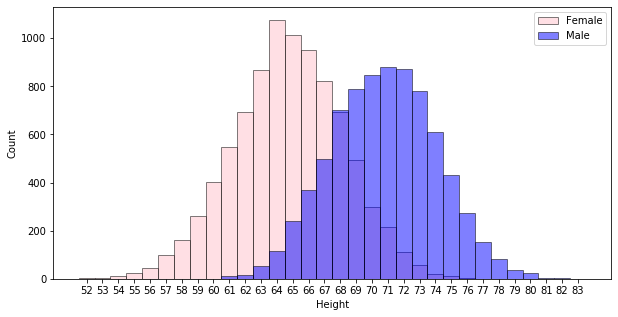

In [14]:
showHistograms(HF, HM, minheight, maxheight)

### Partial Data Histogram Classifier

In [0]:
X50 = X[:50]
T50 = T[:50]

In [0]:
[HF50, HM50] = BuildHistogramClassifiers(X50, T50, B, minheight, maxheight)

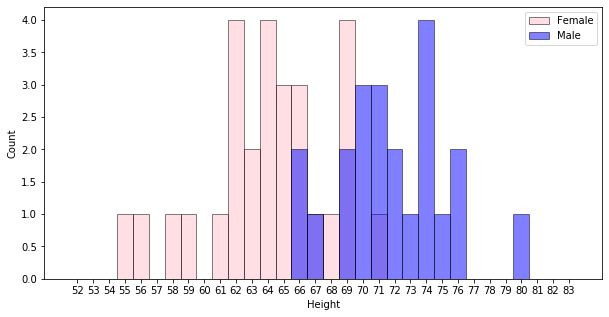

In [17]:
showHistograms(HF50, HM50, minheight, maxheight)

In [18]:
[GH50, PH50] = ApplyHistogramClassifiers(queries, HF50, HM50, minheight, maxheight)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [19]:
showResult(queries, GH50, PH50)

   Query         Gender Probability
0   55.0         Female           1
1   60.0  Indeterminate         NaN
2   65.0         Female           1
3   70.0           Male           1
4   75.0           Male           1
5   80.0           Male           1


In [20]:
showResult(queries, GH, PH)

   Query  Gender Probability
0   55.0  Female           1
1   60.0  Female    0.997531
2   65.0  Female    0.807815
3   70.0    Male    0.739547
4   75.0    Male    0.972973
5   80.0    Male           1


# Bayesian

### Full Data Bayesian Classifier

In [0]:
def BuildBayesianClassifier(X, T):
  muF = np.mean(X[T=='Female'])
  muM = np.mean(X[T=='Male'])
  sigmaF = np.std(X[T=='Female'], ddof=1)
  sigmaM = np.std(X[T=='Male'], ddof=1)
  NF = len(T[T=='Female'])
  NM = len(T[T=='Male'])
  return [muF, muM, sigmaF, sigmaM, NF, NM]


In [0]:
[muF, muM, sigmaF, sigmaM, NF, NM] = BuildBayesianClassifier(X, T)

In [23]:
[muF, muM, sigmaF, sigmaM, NF, NM]

[64.72573033707866,
 70.76807692307692,
 3.478434480283158,
 3.3096673675130455,
 8900,
 7800]

In [0]:
def pdf(x, mu, sigma):
  return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-0.5*((x-mu)/sigma)**2)

In [25]:
pdf(0, 0, 1)

0.3989422804014327

In [0]:
def ApplyBayesianClassifier(queries, muF, muM, sigmaF, sigmaM, NF, NM):
  w = 1
  countF = NF*w*pdf(queries, muF, sigmaF)
  countM = NM*w*pdf(queries, muM, sigmaM)
  resultlabels = np.full(len(queries), 'Indeterminate', dtype=object)
  resultprobs = np.full(len(queries), np.nan, dtype=object)
  indicesF = countF>countM
  indicesM = countM>countF
  probF=countF/(countF+countM)
  probM=countM/(countF+countM)
  resultlabels[indicesF] = 'Female'
  resultlabels[indicesM] = 'Male'
  resultprobs[indicesF] = probF[indicesF]
  resultprobs[indicesM] = probM[indicesM]
  return [resultlabels, resultprobs]

In [0]:
[GB, PB] = ApplyBayesianClassifier(queries, muF, muM, sigmaF, sigmaM, NF, NM)

In [28]:
showResult(queries, GB, PB)

   Query  Gender Probability
0   55.0  Female    0.999459
1   60.0  Female    0.988479
2   65.0  Female    0.831704
3   70.0    Male    0.738932
4   75.0    Male    0.969602
5   80.0    Male    0.996559


In [29]:
showResult(queries, GH, PH)

   Query  Gender Probability
0   55.0  Female           1
1   60.0  Female    0.997531
2   65.0  Female    0.807815
3   70.0    Male    0.739547
4   75.0    Male    0.972973
5   80.0    Male           1


### Partial Data Bayesian Classifier

In [0]:
[muF50, muM50, sigmaF50, sigmaM50, NF50, NM50] = BuildBayesianClassifier(X50, T50)

In [31]:
[muF50, muM50, sigmaF50, sigmaM50, NF50, NM50]

[64.07142857142857,
 71.81818181818181,
 3.9527634161860257,
 3.459099299726443,
 28,
 22]

In [0]:
[GB50, PB50] = ApplyBayesianClassifier(queries, muF50, muM50, sigmaF50, sigmaM50, NF50, NM50)

# Summary

In [33]:
showAllResults(queries, GH, PH, GH50, PH50, GB, PB, GB50, PB50)

,Query,GH,PH,GH50,PH50,GB,PB,GB50,PB50
0,55.0,Female,1,Female,1,Female,0.999459,Female,0.999908
1,60.0,Female,0.997531,Indeterminate,NaN,Female,0.988479,Female,0.995565
2,65.0,Female,0.807815,Female,1,Female,0.831704,Female,0.883165
3,70.0,Male,0.739547,Male,1,Male,0.738932,Male,0.706592
4,75.0,Male,0.972973,Male,1,Male,0.969602,Male,0.964127
5,80.0,Male,1,Male,1,Male,0.996559,Male,0.994591


# Export Results

In [34]:
check_all_vars(all_vars)

minheight exists.
maxheight exists.
HF exists.
HM exists.
muF exists.
muM exists.
sigmaF exists.
sigmaM exists.
NF exists.
NM exists.
HF50 exists.
HM50 exists.
muF50 exists.
muM50 exists.
sigmaF50 exists.
sigmaM50 exists.
NF50 exists.
NM50 exists.
GH exists.
PH exists.
GB exists.
PB exists.
GH50 exists.
PH50 exists.
GB50 exists.
PB50 exists.


In [35]:
print("Please wait. Writing to Excel ...")
writeExcelData([minheight,maxheight],excelfile,'Classifiers - Full Data',1,2)
writeExcelData([HF],excelfile,'Classifiers - Full Data',5,3)
writeExcelData([HM],excelfile,'Classifiers - Full Data',6,3)
writeExcelData([muF,muM],excelfile,'Classifiers - Full Data',8,3)
writeExcelData([sigmaF,sigmaM],excelfile,'Classifiers - Full Data',11,3)
writeExcelData([NF,NM],excelfile,'Classifiers - Full Data',14,3)
print("Written Sheet \'Classifiers - Full Data\'")

writeExcelData([minheight,maxheight],excelfile,'Classifiers - Partial Data',1,2)
writeExcelData([HF50],excelfile,'Classifiers - Partial Data',5,3)
writeExcelData([HM50],excelfile,'Classifiers - Partial Data',6,3)
writeExcelData([muF50,muM50],excelfile,'Classifiers - Partial Data',8,3)
writeExcelData([sigmaF50,sigmaM50],excelfile,'Classifiers - Partial Data',11,3)
writeExcelData([NF50,NM50],excelfile,'Classifiers - Partial Data',14,3)
print("Written Sheet \'Classifiers - Partial Data\'")

writeExcelData(list(zip(*[GH,PH,GB,PB])),excelfile,'Queries',3,2)
writeExcelData(list(zip(*[GH50,PH50,GB50,PB50])),excelfile,'Queries',12,2)
print("Written Sheet \'Queries\'")
closeExcelFile(excelfile)
print("DONE!")

Please wait. Writing to Excel ...
Written Sheet 'Classifiers - Full Data'
Written Sheet 'Classifiers - Partial Data'
Written Sheet 'Queries'
DONE!
